In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy import interp
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [11]:
df = pd.read_csv('FoodFacts.csv')

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,3,5,27,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
# Don't need code column
df.drop(['code', 'created_t', 'last_modified_datetime'], axis=1, inplace=True)

In [13]:
from collections import Counter
def cleanLists(l):
    if type(l) != list:
        return []
    else:
        return [cat.strip().lower() for cat in l]

def oneHotEncodeCategories(df, numCategories=10):
    '''
        df: dataframe
        numCategories: how many categories, starting with the most common categories, to one hot encode.
        returns: 
            df: dataframe with categories one hot encoded. 
            category_columns: the names of the one hot encoded category columns
    '''
    
    df['categories_en_list'] = df.categories_en.apply(lambda x: x.split(',') if type(x) == str else x)
    df['categories_en_list'] = df.categories_en_list.apply(cleanLists)
    
    all_cats = []
    _ = df.categories_en_list.apply(lambda x: all_cats.extend(x))
    cat_counts = Counter(all_cats)
    most_common_cats = [cat[0] for cat in cat_counts.most_common(numCategories)]
    for cat in most_common_cats:
        df[cat] = df['categories_en_list'].apply(lambda x: 1 if cat in x else 0)
    return df, most_common_cats

df, category_columns = oneHotEncodeCategories(df, numCategories=100)

In [16]:

#https://www.kaggle.com/christinampoid/d/openfoodfacts/world-food-facts/europe-habits

#labels: list of Strings with country names
#returns the rows that have as country name any of the names in labels
def get_rows_country(labels):
    return df[df.countries.isin(labels)]

#labels: list of Strings with country names
#returns the categories and the percentage that appear in the rows of a particular country
def get_categories_counts(labels):
    rows = get_rows_country(labels)
    food_country = rows.main_category_en.value_counts() / len(rows)*100
    return food_country

#France
labels_france = ['France', 'en:FR', 'France,Europe','Belgique,France']
french_food = get_rows_country(labels_france)

#Spain
labels_spain = ['España','en:ES','Espagne','Spain']
spanish_food = get_rows_country(labels_spain)

#Germany
labels_germany = ['Deutschland','Germany','Allemagne','en:DE']
german_food = get_rows_country(labels_germany)

#United Kingdom
labels_uk = ['en:UK','United Kingdom','en:GB','uk','UK']
uk_food = get_rows_country(labels_uk)

#Belgium
labels_belgium = ['Belgique','en:BE','Belgique,France','Belgium','Belgique,France']
belgium_food = get_rows_country(labels_belgium)

#Italia
labels_italia = ['Italia','en:IT','Italie']
italian_food = get_rows_country(labels_italia)

#Switzerland
labels_switzerland = ['Suisse','Switzerland']
suisse_food = get_rows_country(labels_switzerland)

#Netherlands
labels_netherlands = ['Netherlands', 'Holland']
holland_food = get_rows_country(labels_netherlands)

#Denmark
labels_denmark = ['Denmark','Dänemark']
dannish_food = get_rows_country(labels_denmark)

#Portugal
labels_portugal = ['Portugal','en:portugal']
portuguese_food = get_rows_country(labels_portugal)

#Greece
labels_greece = ['Greece','en:GR','Grèce','en:greece']
greek_food = get_rows_country(labels_greece)

#Sweden
labels_sweden = ['Sweden','en:SE','en:sweden']
swedish_food = get_rows_country(labels_sweden)

#Norway
labels_norway = ['Norway','en:NO','en:norway']
norwegian_food = get_rows_country(labels_norway)

#Croatia
labels_croatia = ['Croatia','en:HR','en:croatia']
croatian_food = get_rows_country(labels_croatia)

#Albania
labels_albania = ['Albania','en:AL','en:albania']
albanian_food = get_rows_country(labels_albania)

labels_usa = ['United States', 'en:US', 'US', 'USA', 'en:united-states','United states', 'united states', 'United States of America']
usa = get_rows_country(labels_usa)

In [17]:
europe = pd.concat([french_food,
                    spanish_food,
                    german_food, 
                    uk_food, 
                    belgium_food, 
                    italian_food, 
                    suisse_food,
                    holland_food,
                    dannish_food, 
                    portuguese_food, 
                    greek_food, 
                    swedish_food,
                    norwegian_food,
                    croatian_food, 
                    albanian_food])

In [18]:
usaNaCols = [col for col in usa.columns if usa[col].isnull().all()]
euroNaCols = [col for col in europe.columns if europe[col].isnull().all()]
combinedNaCols = usaNaCols + euroNaCols

usa = usa.drop(combinedNaCols, axis=1)
europe = europe.drop(combinedNaCols, axis=1)
usa['isUS'] = 1
europe['isUS'] = 0
print(europe.shape)
print(usa.shape)


(55942, 205)
(2413, 205)


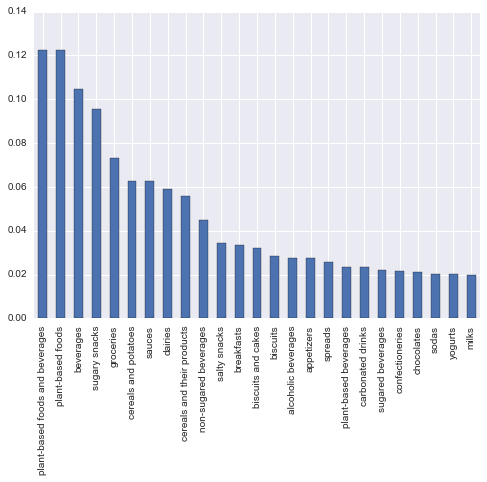

In [20]:
most_common_usa = usa[category_columns].sum().sort_values(ascending=False).iloc[0:25]
most_common_usa_perc = most_common_usa.apply(lambda x: x/usa.shape[0])
most_common_usa_perc.plot(kind='bar')

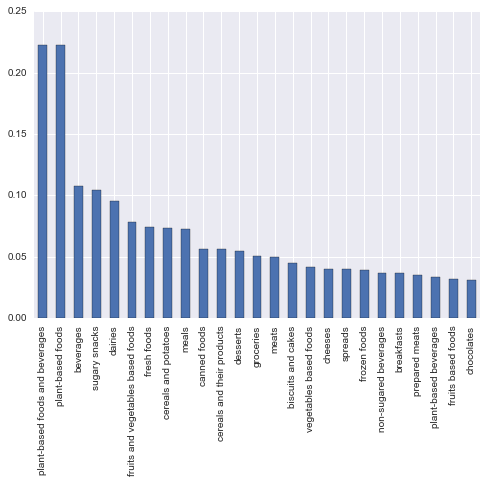

In [21]:
most_common_euro = europe[category_columns].sum().sort_values(ascending=False).iloc[0:25]
most_common_euro = most_common_euro.apply(lambda x: x/europe.shape[0])
most_common_euro.plot(kind='bar')

In [24]:
most_common_in_both = [cat for cat in most_common_usa.index if cat in most_common_euro.index]
most_common_in_both

['plant-based foods and beverages',
 'plant-based foods',
 'beverages',
 'sugary snacks',
 'groceries',
 'cereals and potatoes',
 'dairies',
 'cereals and their products',
 'non-sugared beverages',
 'breakfasts',
 'biscuits and cakes',
 'spreads',
 'plant-based beverages',
 'chocolates']

In [40]:
train = pd.concat([usa, europe])
numericCols = train.select_dtypes(include=[np.number]).columns
dfNumOnly = train[numericCols]
dfNumOnly.fillna(0, inplace=True)
models = []
toDrop = ['isUS']
toDrop.extend(category_columns)
print(toDrop)
for cat in most_common_in_both:
    cat_rows = dfNumOnly[dfNumOnly[cat] == 1]
    X = cat_rows.drop(toDrop, axis=1)
    print(X.columns)
    y = cat_rows['isUS'].values
    (Xtrain, Xtest, yTrain, yTest) = cross_validation.train_test_split(X, y, stratify=y)
    clf = LogisticRegression()
    sc = StandardScaler()
    X = sc.fit_transform(X)
    clf.fit(Xtrain, yTrain)
    preds = clf.predict(Xtest)
    print(cat)
    auc_score = roc_auc_score(preds, yTest)
    models.append((cat, auc_score,  clf))

//anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2756: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


['isUS', 'plant-based foods and beverages', 'plant-based foods', 'beverages', 'sugary snacks', 'dairies', 'fruits and vegetables based foods', 'cereals and potatoes', 'fresh foods', 'meals', 'cereals and their products', 'canned foods', 'groceries', 'desserts', 'meats', 'biscuits and cakes', 'vegetables based foods', 'spreads', 'cheeses', 'non-sugared beverages', 'frozen foods', 'breakfasts', 'plant-based beverages', 'sauces', 'prepared meats', 'chocolates', 'fruits based foods', 'biscuits', 'alcoholic beverages', 'confectioneries', 'seafood', 'fruit-based beverages', 'salty snacks', 'canned plant-based foods', 'appetizers', 'condiments', 'juices and nectars', 'yogurts', 'fishes', 'non-alcoholic beverages', 'sugared beverages', 'fruit juices and nectars', 'legumes and their products', 'pastas', 'sweet spreads', 'hot beverages', 'cow cheeses', 'fruit juices', 'fresh plant-based foods', 'seeds', 'carbonated drinks', 'breads', 'fats', 'milks', 'plant-based spreads', 'pasteurized cheeses',

In [41]:
modelDf = pd.DataFrame(columns=['category', 'auc', 'clf'])
for model in models:
    modelDf = modelDf.append({'category': model[0], 'auc': model[1], 'clf': model[2]}, ignore_index=True)
modelDf[['category', 'auc']]

,category,auc
0,plant-based foods and beverages,0.979
1,plant-based foods,0.958
2,beverages,0.981
3,sugary snacks,0.991
4,groceries,0.981
5,cereals and potatoes,0.953
6,dairies,0.993
7,cereals and their products,0.964
8,non-sugared beverages,0.853
9,breakfasts,0.987


In [43]:
spreads_clf = modelDf[modelDf.category == 'spreads'].clf
spreads_coef = pd.DataFrame({'value': clf.coef_[0], 'absVal': abs(clf.coef_[0]), 'feature': dfNumOnly.drop(toDrop, axis=1).columns})
spreads_coef.sort_values(by='absVal', ascending=False).iloc[0:10]

,absVal,feature,value
1,0.779,ingredients_from_palm_oil_n,-0.779
2,0.698,ingredients_that_may_be_from_palm_oil_n,-0.698
18,0.499,proteins_100g,-0.499
19,0.377,salt_100g,-0.377
5,0.235,fat_100g,0.235
49,0.232,cocoa_100g,-0.232
16,0.193,polyols_100g,-0.193
8,0.165,polyunsaturated_fat_100g,0.165
20,0.148,sodium_100g,-0.148
21,0.127,alcohol_100g,-0.127


In [42]:
#sns.distplot(usa[usa.beverages == 1].sugars_100g)
usa_bevs = usa[usa.beverages == 1]
europe_bevs = europe[europe.beverages == 1]
europe_bevs.generic_name

8                                                      NaN
13       Boisson gazeuse rafraîchissante aux extraits n...
16       Boisson gazeuse aux extraits naturels de citro...
27                                                     NaN
95                                                     NaN
306                                                    NaN
458                              Lait de coco pour dessert
462                         Boisson aux graines de basilic
463                                                    NaN
465                                                    NaN
512                                                    NaN
687                                                    NaN
1072                                                   NaN
1305                                                   NaN
1663                                                   NaN
1706                                       boisson au cola
1726                                                   N

In [ ]:
usaNumOnly = usaNumOnly.drop(combinedNaCols, axis=1)
europeNumOnly = europeNumOnly.drop(combinedNaCols, axis=1)
print(europeNumOnly.shape)
print(usaNumOnly.shape)

In [12]:
usaNumOnly['isUS'] = 1
europeNumOnly['isUS'] = 0
train = pd.concat([usaNumOnly, europeNumOnly])

In [13]:
train = train.fillna(0, axis=0)

In [14]:
train.head()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,energy_from_fat_100g,fat_100g,saturated_fat_100g,monounsaturated_fat_100g,polyunsaturated_fat_100g,omega_3_fat_100g,...,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,fruits_vegetables_nuts_100g,cocoa_100g,carbon_footprint_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,isUS
20,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
56,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
78,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
83,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
87,3.000,0.000,0.000,761.000,275.000,7.580,4.040,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,4.000,1


In [15]:
usaFattiest = train[train['isUS'] == 1].energy_from_fat_100g.sort_values(ascending=False)
usa.ix[usaFattiest.index.values, :][['product_name', 'energy_from_fat_100g']].head(10)

,product_name,energy_from_fat_100g
5141,Lemon Ginger,3740.000
683,Virgin coconut oil,3590.000
641,Corn Oil,3350.000
3612,NaN,3350.000
2922,Mayonnaise,3220.000
2934,Mayonnaise,3220.000
2276,Grade AA Butter,2990.000
4653,Sweat Cream Butter,2990.000
1672,Real Mayonnaise,2990.000
1000,Real Mayonnaise,2990.000


In [16]:
euroFattiest = train[train['isUS'] == 0].energy_from_fat_100g.sort_values(ascending=False)
europe.ix[euroFattiest.index.values, :][['product_name', 'energy_from_fat_100g']].head(10)

,product_name,energy_from_fat_100g
5217,Dark Chocolate with Almonds,1420.000
59124,Chocolat au lait et gaufrette,1140.000
41801,La Galette fine Chocolat,741.000
34576,Chocolat en poudre lacté 4 étoiles,167.000
4603,ISO 100 Hydrolyzed 100% Whey Protein Isolate,66.200
26098,Biscuits sablés à la noix de coco Leader Price,nan
26097,Boudoirs aux oeufs frais,nan
26096,Tartelettes au Citron Pur Beurre,nan
26095,Tartelettes à la fraise,nan
26094,Gaufres au miel bio,nan


In [18]:
usaMostChol = train[train['isUS'] == 1].cholesterol_100g.sort_values(ascending=False)
usa.ix[usaMostChol.index.values, :][['product_name', 'cholesterol_100g']].head(10)

,product_name,cholesterol_100g
2748,6 grade A large brown eggs,0.432
2525,12 large grade cage free AA eggs,0.430
4654,Large Grade AA 5 Dozen Eggs,0.430
1804,6 large grade AA eggs,0.370
4640,Egg Land's best,0.357
178,Saki Ika Prepared Squid (Hot),0.306
1231,Wild Caught Shrimp,0.223
391,European style unsalted butter,0.214
1470,Challenge Butter unsalted,0.214
4653,Sweat Cream Butter,0.214


In [20]:
euroMostChol = train[train['isUS'] == 0].cholesterol_100g.sort_values(ascending=False)
europe.ix[euroMostChol.index.values, :][['product_name', 'cholesterol_100g']].head(10)

,product_name,cholesterol_100g
27934,6 Oeufs Frais Bio,0.378
52486,Manteiga com sal,0.230
22438,Beurre d'Isigny,0.214
34575,Palets pur beurre,0.213
57548,Pandoro traditionnel italien,0.175
6492,Tentacules d'encornet géant,0.168
57243,La colomba,0.150
14683,Assortiment Traou Mad et galettes de Pont-Aven,0.130
4592,Palets aux Perles de Chocolat,0.127
43420,Gressins Tomate Origan,0.080


In [21]:
usa.categories.value_counts().sort_values(ascending=False)

Plant-based foods and beverages,Plant-based foods,Cereals and potatoes,Cereals and their products,Pastas                                                                                     24
Sugary snacks,Biscuits and cakes,Biscuits,Cookies                                                                                                                                            19
Plant-based foods and beverages,Plant-based foods,Breakfasts,Cereals and potatoes,Cereals and their products,Breakfast cereals                                                               19
Sugary snacks,Confectioneries,Candies                                                                                                                                                        19
Plant-based foods and beverages,Plant-based foods,Cereals and potatoes,Cereals and their products,Noodles,Instant noodles                                                                    14
Groceries,Sauces,Tomato sauces,Ketchup  

### Fit various models to assess the predictive power of each ingredient in distinguishing Euro foods from USA foods

In [93]:
def makeTrainingSet(colsToDrop=[]):
    X = train.drop(['isUS'] + colsToDrop, axis=1)
    y = train['isUS']
    return (X, y)

def makeCoefDf(clf, X):
    coef_df = pd.DataFrame({'value': clf.coef_[0], 'absVal': abs(clf.coef_[0]), 'feature': X.columns })
    return coef_df.sort_values(by='absVal', ascending=False)

def makeFeatureImpDf(clf, X):
    coef_df = pd.DataFrame({'value': clf.feature_importances_[0], 'feature': X.columns })
    return coef_df.sort_values(by='value', ascending=False)

In [33]:
from sklearn.linear_model import LogisticRegression
(X, y) = makeTrainingSet(colsToDrop = [])
clf = LogisticRegression()
clf.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
lr_coef_one = makeCoefDf(clf, X)

In [35]:
lr_coef_one.iloc[0:10, :]

,absVal,feature,value
1,2.582,ingredients_from_palm_oil_n,-2.582
2,1.675,ingredients_that_may_be_from_palm_oil_n,-1.675
12,1.404,cholesterol_100g,1.404
9,0.790,omega_3_fat_100g,-0.790
31,0.528,vitamin_b9_100g,0.528
40,0.526,zinc_100g,0.526
15,0.273,lactose_100g,-0.273
10,0.222,alpha_linolenic_acid_100g,-0.222
39,0.174,magnesium_100g,-0.174
38,0.169,iron_100g,0.169


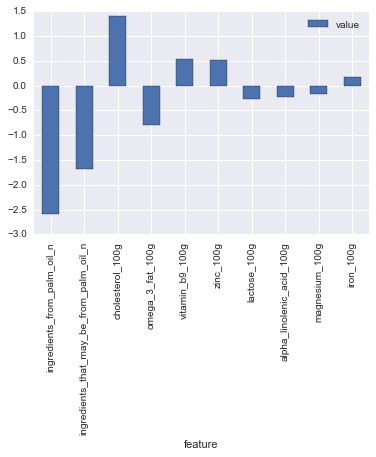

In [36]:
lr_coef_one.iloc[0:10, :].plot(kind='bar', x='feature', y='value')

It seems like many palm oil may indicate that a product is European. But that doesn't mean that European products are more likely to contain it than US products. In Europe, palm oil is required on food labels. In the US, it isn't:

- https://www.theguardian.com/sustainable-business/2014/dec/12/eu-labelling-changes-palm-oil-consumer-change
- http://www.eurofoodlaw.com/labelling/analysis-palm-oil-no-longer-a-hidden-ingredient-108325.htm


Now let's try a random forest.

In [37]:
from sklearn.ensemble import RandomForestClassifier as rf
clf = rf(max_depth=5)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
#importances_df.iloc[0:10, :].plot(kind='bar', x='feature', y='value')

hmm..it looks like palm oil isn't very important to our random forest. Let's remove palm oil, and see what happes. We'll also drop uk_nutrition_score and france_nutrition_score, as US products wouldn't have those on their labels.

In [98]:
colsToDrop = ['ingredients_from_palm_oil_n', 
              'ingredients_that_may_be_from_palm_oil_n', 
              'nutrition_score_uk_100g',
              'nutrition_score_fr_100g']
train = train.drop(colsToDrop, axis=1)

clf = LogisticRegression()
(X, y) = makeTrainingSet()
clf.fit(X,y)
coef_wo_palm_df = makeCoefDf(clf, X)
coef_wo_palm_df.iloc[0:10, :]

,absVal,feature,value
0,0.084,additives_n,-0.084
6,0.081,polyunsaturated_fat_100g,0.081
30,0.078,vitamin_b12_100g,0.078
46,0.066,fruits_vegetables_nuts_100g,-0.066
14,0.065,polyols_100g,-0.065
33,0.063,potassium_100g,0.063
4,0.055,saturated_fat_100g,0.055
2,0.054,energy_from_fat_100g,0.054
47,0.051,cocoa_100g,-0.051
16,0.047,proteins_100g,-0.047


In [40]:
from sklearn.ensemble import RandomForestClassifier as rf
clf = rf(max_depth=5)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
importances_wo_palm_df = makeFeatureImpDf(clf, X) 
importances_wo_palm_df

,feature,value
0,additives_n,0.007
25,vitamin_b1_100g,0.007
27,vitamin_pp_100g,0.007
28,vitamin_b6_100g,0.007
29,vitamin_b9_100g,0.007
30,vitamin_b12_100g,0.007
31,biotin_100g,0.007
32,pantothenic_acid_100g,0.007
33,potassium_100g,0.007
34,calcium_100g,0.007


Without palm oil, the random forest has gone haywire

Let's look at correlation coeffiecients.

In [42]:
corr_df = pd.DataFrame({'feature': [], 'pval': [], 'value': []})

from scipy.stats import pointbiserialr
(X, y) = makeTrainingSet()


for col in train.drop(['isUS'], axis= 1).columns:
    corr = pointbiserialr(train['isUS'].values, train[col].values)
    corr_df = corr_df.append(pd.Series({'feature': col, 'pval':corr.pvalue, 'value': corr.correlation, 'absVal': abs(corr.correlation)}), ignore_index=True)

corr_df.sort_values(by='absVal', ascending=False, inplace=True)
corr_df.iloc[0:10, :]

,feature,pval,value,absVal
2,energy_from_fat_100g,0.000,0.340,0.340
10,cholesterol_100g,0.000,0.199,0.199
9,trans_fat_100g,0.000,0.039,0.039
16,proteins_100g,0.000,-0.037,0.037
0,additives_n,0.000,-0.031,0.031
6,polyunsaturated_fat_100g,0.000,0.025,0.025
46,fruits_vegetables_nuts_100g,0.000,-0.022,0.022
42,chromium_100g,0.000,0.021,0.021
38,zinc_100g,0.000,0.021,0.021
1,energy_100g,0.000,-0.021,0.021


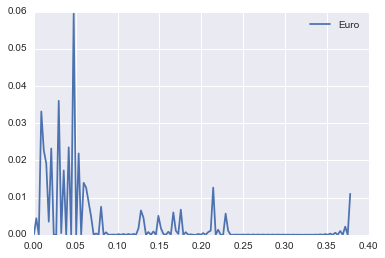

In [43]:
us = train[train['isUS'] == 1]
euro = train[train['isUS'] == 0]
#sns.kdeplot(us['cholesterol_100g'], label='US')
sns.kdeplot(euro['cholesterol_100g'], label='Euro')

In [44]:
sns.kdeplot(us['cholesterol'], label='US')
sns.kdeplot(euro['cholesterol'], label='Euro')

KeyError: 'cholesterol'

In [45]:
euro['energy_from_fat_100g'].max()

1420.0

In [ ]:
top_features = corr_df.iloc[0:4, :]['feature']
g = sns.pairplot(train[top_features])

In [ ]:
(X, y) = makeTrainingSet()
(Xtrain, Xtest, yTrain, yTest) = cross_validation.train_test_split(X, y)
clf = LogisticRegression(class_weight='balanced')
clf.fit(Xtrain, yTrain)
print('F1 Score: {}'.format(f1_score(yTest.values, clf.predict(Xtest.values))))
print('AUC: {}'.format(roc_auc_score(clf.predict(Xtest.values), yTest.values)))
print('Precision: {}'.format(precision_score(y_true=yTest.values,y_pred= clf.predict(Xtest.values))))
print('Recall: {}'.format(recall_score(y_true=yTest.values,y_pred= clf.predict(Xtest.values))))
print('Accuracy: {}'.format(accuracy_score(y_true=yTest.values,y_pred= clf.predict(Xtest.values))))

We might as well be guessing randomly. Particularly, the precision score indicates we're making many false positive errors, predicting European foods as US foods.

In [ ]:
clf = rf(class_weight='balanced', max_depth=5)
clf.fit(Xtrain, yTrain)
print('F1 Score: {}'.format(f1_score(yTest.values, clf.predict(Xtest.values))))
print('AUC: {}'.format(roc_auc_score(clf.predict(Xtest.values), yTest.values)))
print('Precision: {}'.format(precision_score(y_true=yTest.values,y_pred= clf.predict(Xtest.values))))
print('Recall: {}'.format(recall_score(ytrue=yTest.values,y_pred= clf.predict(Xtest.values))))
print('Accuracy: {}'.format(accuracy_score(y_true=yTest.values,y_pred= clf.predict(Xtest.values))))

In [ ]:
plt.scatter(train.energy_from_fat_100g, train.cholesterol_100g, c=train.isEuro)
plt.xlabel('energy from fat')
plt.ylabel('cholesterol')
plt.legend(loc='best')

In [46]:
X = train.drop(['isUS'], axis=1).values
y = train['isUS'].values
(Xtrain, Xtest, yTrain, yTest) = cross_validation.train_test_split(X, y, stratify=y)
clf = LogisticRegression()
sc = StandardScaler()
X = sc.fit_transform(X)
params = {'C': [0.01, 0.1, 1, 10, 100, 1000]}
gs = GridSearchCV(clf, param_grid=params, scoring='roc_auc')
gs.fit(Xtrain, yTrain)

print('best C: {}'.format(gs.best_params_['C']))
print('best AUC: {}'.format(gs.best_score_))




best C: 100
best AUC: 0.7807087912670242


In [82]:
#preds = gs.predict(Xtest)
probas = gs.predict_proba(Xtest)
preds = [1 if x > 0.37 else 0 for x in probas[:, 1]]
print('Test Set AUC: {}'.format(roc_auc_score(preds, yTest)))
print('Accuracy: {}'.format(accuracy_score(y_true=yTest, y_pred= preds)))

Test Set AUC: 0.9544634491784633
Accuracy: 0.9678524916032627


In [81]:
confusion_matrix(y_true=yTest, y_pred= preds)

array([[13959,    27],
       [  448,   155]])

In [90]:
100 - (sum(yTest) / len(yTest) * 100)

95.866748920419496

In [100]:
(X_df, y) = makeTrainingSet()
coef_df = makeCoefDf(gs.best_estimator_, X_df)
coef_df.iloc[0:10, :]

,absVal,feature,value
47,2.078,cocoa_100g,-2.078
7,0.389,omega_3_fat_100g,-0.389
10,0.281,cholesterol_100g,0.281
14,0.179,polyols_100g,-0.179
30,0.130,vitamin_b12_100g,0.130
8,0.117,alpha_linolenic_acid_100g,-0.117
13,0.104,lactose_100g,-0.104
48,0.096,carbon_footprint_100g,-0.096
33,0.088,potassium_100g,0.088
6,0.085,polyunsaturated_fat_100g,0.085


In [106]:
print(train[train['isUS'] == 1].cocoa_100g.mean())
train[train['isUS'] == 0].cocoa_100g.mean()

0.024865312888520515


0.3447213185084552

In [83]:
def makeConfusionDf(true, pred):
    c = confusion_matrix(y_true=yTest, y_pred= preds) 
    return pd.DataFrame(c, columns=['Pred 0', 'Pred 1'], index=['Acutal 0', 'Acutal 1'])
makeConfusionDf(yTest, preds)

,Pred 0,Pred 1
Acutal 0,13977,9
Acutal 1,460,143


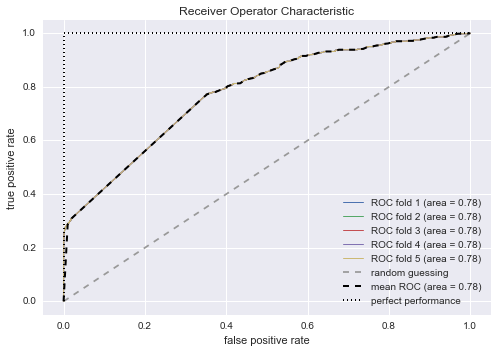

In [64]:
cv = cross_validation.StratifiedKFold(y, n_folds=5, random_state=2)

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []


for i, (train, test) in enumerate(cv):
    probas = gs.predict_proba(Xtest)
    
    fpr, tpr, thresholds = roc_curve(yTest,
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
strat_df = makeCoefDf(clf, train.drop(['isUS'], axis=1))
strat_df.iloc[0:10, :]

### Let's explore the how US and Euro foods differ within food categories